In [1]:
import torch, pypose as pp
import pandas as pd
import numpy as np
import manifpy as mp
#from manifpy import SE3, SE3Tangent

from scipy.spatial.transform import Rotation as R
from RNN_AUV import plot_traj

/home/pierre/anaconda3/envs/pypose/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = "./test_data_clean/csv/run0.csv"
df = pd.read_csv(path)

position = df.loc[:, ['x', 'y', 'z']].to_numpy()
orientation = df.loc[:, ['roll', 'pitch', 'yaw']].to_numpy()
euler_traj = np.concatenate([position, orientation], axis=-1)
manif_quat = df.loc[:, ['qw', 'qx', 'qy', 'qz']].to_numpy()
pp_quat = df.loc[:, ['qx', 'qy', 'qz', 'qw']].to_numpy()
rot_matrix = df.loc[:, ['r00', 'r01', 'r02', 'r10', 'r11', 'r12', 'r20', 'r21', 'r22']].to_numpy().reshape((-1, 3, 3))
rot_vec = df.loc[:, ['rv0', 'rv1', 'rv2']].to_numpy()
I_vel = df.loc[:, ['Iu', 'Iv', 'Iw', 'Ip', 'Iq', 'Ir']].to_numpy()
B_vel = df.loc[:, ['Bu', 'Bv', 'Bw', 'Bp', 'Bq', 'Br']].to_numpy()

# LieTensor Tutorial
## 1. Initialization

First let's try to create an SE3 element from the first state of the bag file and compare it to the manif implementation.

PyPose has quaternion representation (qx, qy, qz, qw) in opposition to manif which has (qw, qx, qy, qz)

In [3]:
quat_traj = np.concatenate([position, pp_quat], axis=-1)
pp_s0 = quat_traj[0]

manif_traj = np.concatenate([position, manif_quat], axis=-1)
manif_s0 = manif_traj[0]

pp_x_init = pp.SE3(pp_s0)
manif_x_init = mp.SE3(manif_s0)

print(pp_x_init)
print(manif_x_init)

print(pp_x_init.data.numpy()-pp_s0)

SE3Type LieTensor:
LieTensor([ 1.7772e-01,  6.2648e-02, -5.9998e+01, -2.0149e-04,  2.1717e-05,
            9.9240e-01,  1.2302e-01])
    0.177716    0.0626485     -59.9985     0.123023 -0.000201487  2.17169e-05     0.992404
[-1.65034314e-09 -3.62723281e-09  1.32146001e-06  5.90143410e-12
  2.62079617e-13  2.56916275e-08 -9.90180909e-10]


Let's see what the exponenetial is doing.

In [4]:
rotvec_traj = np.concatenate([position, rot_vec], axis=-1)

pp_tg = pp.se3(rotvec_traj[0])
manif_tg = mp.SE3Tangent(rotvec_traj[0])

print(pp_tg)
print(manif_tg)

se3Type LieTensor:
LieTensor([ 1.7772e-01,  6.2648e-02, -5.9998e+01, -5.8775e-04,  6.3350e-05,
            2.8949e+00])
    0.177716    0.0626485     -59.9985 -0.000587753    6.335e-05      2.89492


In [5]:
pp_X_init = pp.identity_SE3() + pp_tg
manif_X_init = mp.SE3.Identity() + manif_tg

print(pp_X_init)
print(manif_X_init)

SE3Type LieTensor:
LieTensor([-1.7376e-02,  1.1671e-01, -5.9999e+01, -2.0149e-04,  2.1717e-05,
            9.9240e-01,  1.2302e-01])
  -0.0173763     0.116713     -59.9985 -0.000201487  2.17169e-05     0.992404     0.123023


### Conclusion
We get the same results with pypose and manifpy. Now let's see the integration

## 2. Integration
We have initalized the SE(3) elements in two different ways. One with the SE(3) object and one through the LieAlgebra. They seem equal one to anothere.

Now Let's use the Inertial velocity and the right plus operator to integrate the trajectory.

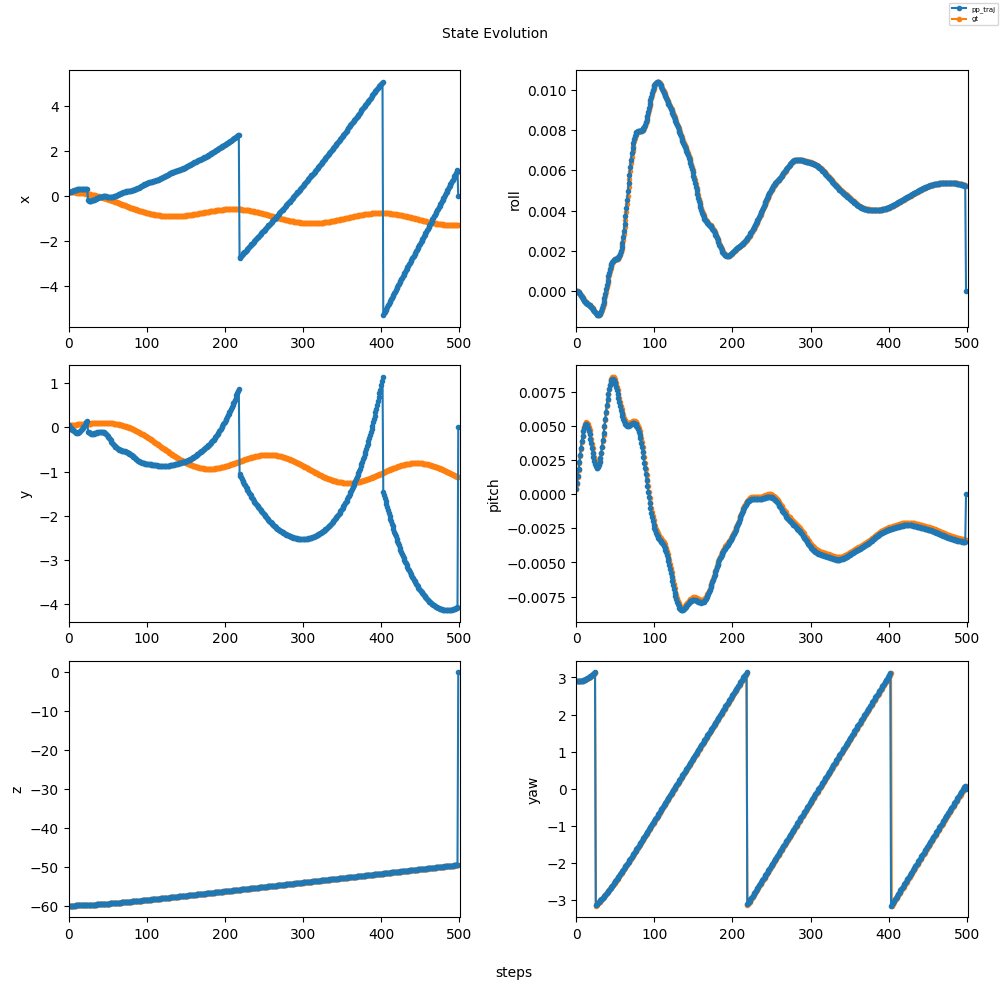

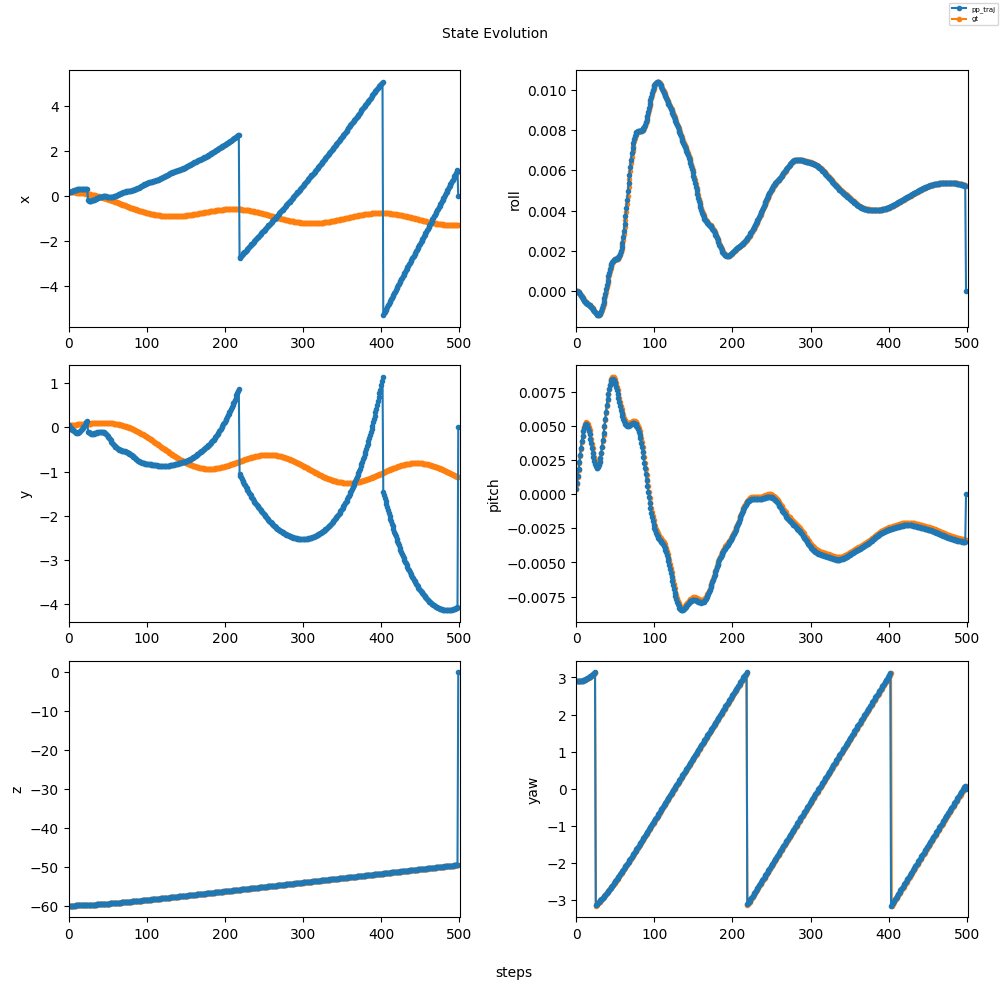

In [6]:
pp_X = pp_X_init
pp_x = pp_x_init

manif_X = manif_X_init
manif_x = manif_x_init

dt = 0.1
gt_vel = I_vel

gt_traj = np.concatenate([position, orientation], axis=-1)

pp_traj = np.zeros(shape=(gt_traj.shape[0], 6))
pp_traj[0] = np.concatenate([position[0], orientation[0]])

pp_traj_tg = np.zeros(shape=(gt_traj.shape[0], 6))
pp_traj_tg[0] = np.concatenate([position[0], orientation[0]])

manif_traj = np.zeros(shape=(gt_traj.shape[0], 6))
manif_traj[0] = np.concatenate([position[0], orientation[0]])

manif_traj_tg = np.zeros(shape=(gt_traj.shape[0], 6))
manif_traj_tg[0] = np.concatenate([position[0], orientation[0]])

for i in range(1, gt_traj.shape[0]-1):
    # Use right operator as we take velocity in Inertial frame.
    pp_lie_alg = pp.se3(gt_vel[i]*dt).Exp()
    pp_x_next = pp_lie_alg * pp_x # generated through tangeant space
    pp_X_next = pp_lie_alg * pp_X # generated through LieGroup constructor
    
    x = pp_x_next.Log().data.numpy()
    X = pp_X_next.Log().data.numpy()

    # Convert quaternion to euler from tg space
    p = X[0:3]
    rv = X[3:]
    r = R.from_rotvec(rv)
    euler = r.as_euler('xyz')
    pp_traj[i] = np.concatenate([p, euler])
    
    # Convert quaternion to euler
    p = x[0:3]
    rv = x[3:]
    r = R.from_rotvec(rv)
    euler = r.as_euler('xyz')
    pp_traj_tg[i] = np.concatenate([p, euler])

    pp_x = pp_x_next
    pp_X = pp_X_next


    manif_lie_alg = mp.SE3Tangent(gt_vel[i]*dt)
    manif_x_next = manif_lie_alg + manif_x # generated through tangeant space
    manif_X_next = manif_lie_alg + manif_X # generated through LieGroup constructor

    x = manif_x_next.log().coeffs_copy()
    X = manif_X_next.log().coeffs_copy()

    p = X[0:3]
    rv = X[3:]
    r = R.from_rotvec(rv)
    euler = r.as_euler('xyz')
    
    manif_traj[i] = np.concatenate([p, euler])
    
    p = x[0:3]
    rv = x[3:]
    r = R.from_rotvec(rv)
    euler = r.as_euler('xyz')
    
    manif_traj_tg[i] = np.concatenate([p, euler])
    
    manif_x = manif_x_next
    manif_X = manif_X_next
    


#s_cols = {'x': 0, 'y': 1, 'z': 2, '$theta 1$': 3, '$theta 2$': 4, '$theta 3$': 5}
#v_cols = {'u': 0, 'v': 1, 'w': 2, 'q': 3, 'p': 4, 'r': 5}
#plot_traj({"Traj": traj, "Traj_quat": traj_quat, "gt": gt_traj}, s_cols, gt_traj.shape[0], True)

eul_cols = {'x': 0, 'y': 1, 'z': 2, 'roll': 3, 'pitch': 4, 'yaw': 5}
#plot_traj({"pp_traj": pp_traj, "pp_traj_tg": pp_traj_tg, "manif_traj": manif_traj, "gt": gt_traj}, eul_cols, 1, True)
plot_traj({"pp_traj": pp_traj, "gt": gt_traj}, eul_cols, 500, True)
#plot_traj({"gt_vel": gt_vel}, v_cols, gt_vel.shape[0], True, "velocity")

# 2. Compute $^B v$ from the pose

For now we assumed that $X_{t+1} = X_{t} \oplus Exp(^B v_{t}*dt)$

So multiplying by the inverse of $X_{t}$ on the right, we have

$X_{t}^{-1} \circ X_{t+1} = Exp(^B v_{t})$

So:

$^B v_{t} = \frac{1}{dt} Log(X_{t}^{-1} \circ X_{t+1})$

In [7]:
pp_x_0 = pp.SE3(quat_traj[0])
pp_x_1 = pp.SE3(quat_traj[1])
pp_x_0_inv = pp_x_0.Inv()

tmp = pp_x_0_inv * pp_x_1

Bv = tmp.Log()/dt

print(B_vel[0])
print(Bv.numpy())

print(B_vel[0] - Bv.numpy())

[-1.88185142e-01 -3.15014628e-03  1.16784237e-02 -4.91812661e-05
  3.12534968e-03 -1.21075771e-04]
[-7.7934784e-04 -2.2654206e-04  1.4076090e-02 -5.5192831e-05
  3.6257729e-03 -1.4349763e-04]
[-1.87405794e-01 -2.92360421e-03 -2.39766667e-03  6.01156542e-06
 -5.00423209e-04  2.24218581e-05]


### 2.1 Verify integration:

In [8]:
print(pp_x_0 * pp.se3(Bv*dt).Exp() - pp_x_1)

tensor([ 2.9802e-08,  0.0000e+00,  0.0000e+00, -2.9104e-11,  0.0000e+00,
         0.0000e+00,  7.4506e-09])


## 3. Now let's compute $^I v$ from pose

Assume that $X_{t+1} = Exp(^I v_{t} * dt) \oplus X_{t}$

Multiplying by the invers of $X_t$ on the left we have

$X_{t+1} \circ X_{t}^{-1} = Exp(^I v_{t} *dt)$

So:

$^I v_{t} = \frac{1}{dt} Log(X_{t+1} \circ X_{t}^{-1})$

In [9]:
pp_x_0 = pp.SE3(quat_traj[0])
pp_x_1 = pp.SE3(quat_traj[1])
pp_x_0_inv = pp_x_0.Inv()

tmp = pp_x_1 * pp_x_0_inv

Iv = tmp.Log()/dt

print(I_vel[0])
print(Iv.numpy())

print(I_vel[0] - Bv.numpy())

[ 6.77789977e-04  2.61231180e-05  1.18910743e-02 -7.15396156e-04
 -3.04276810e-03 -1.21076054e-04]
[-2.1096921e-01  4.9959734e-02  1.3505190e-02 -8.3174917e-04
 -3.5295137e-03 -1.4349872e-04]
[ 1.45713782e-03  2.52665181e-04 -2.18501607e-03 -6.60203324e-04
 -6.66854100e-03  2.24215749e-05]


### 3.1 Verify integration:

In [10]:
print((pp.se3(Iv*dt).Exp() * pp_x_0) - pp_x_1)

tensor([-1.4901e-08, -2.9802e-08,  0.0000e+00, -2.9104e-11,  0.0000e+00,
         0.0000e+00,  7.4506e-09])


## 4. Generate velocity profiles from pose data

Generate $^I v$ and $^B v$ from the pose $X$ as in point 2. and 3. But for all the trajectory.

Using the plotting tool compare the two velocity profiles w.r.t to the one obtained through ROS.

### 4.1 $^B v$

In [11]:
X = pp.SE3(quat_traj)
X_inv = X.Inv()

tmp = X_inv[:-1] * X[1:]

Bv = tmp.Log()/dt

print(Bv.numpy().shape)

(499, 6)


### 4.2 $^I v$

In [12]:
X = pp.SE3(quat_traj)
X_inv = X.Inv()

tmp = X[1:] * X_inv[:-1]

Iv = tmp.Log()/dt

print(Iv.numpy().shape)

(499, 6)


### 4.3 Plotting

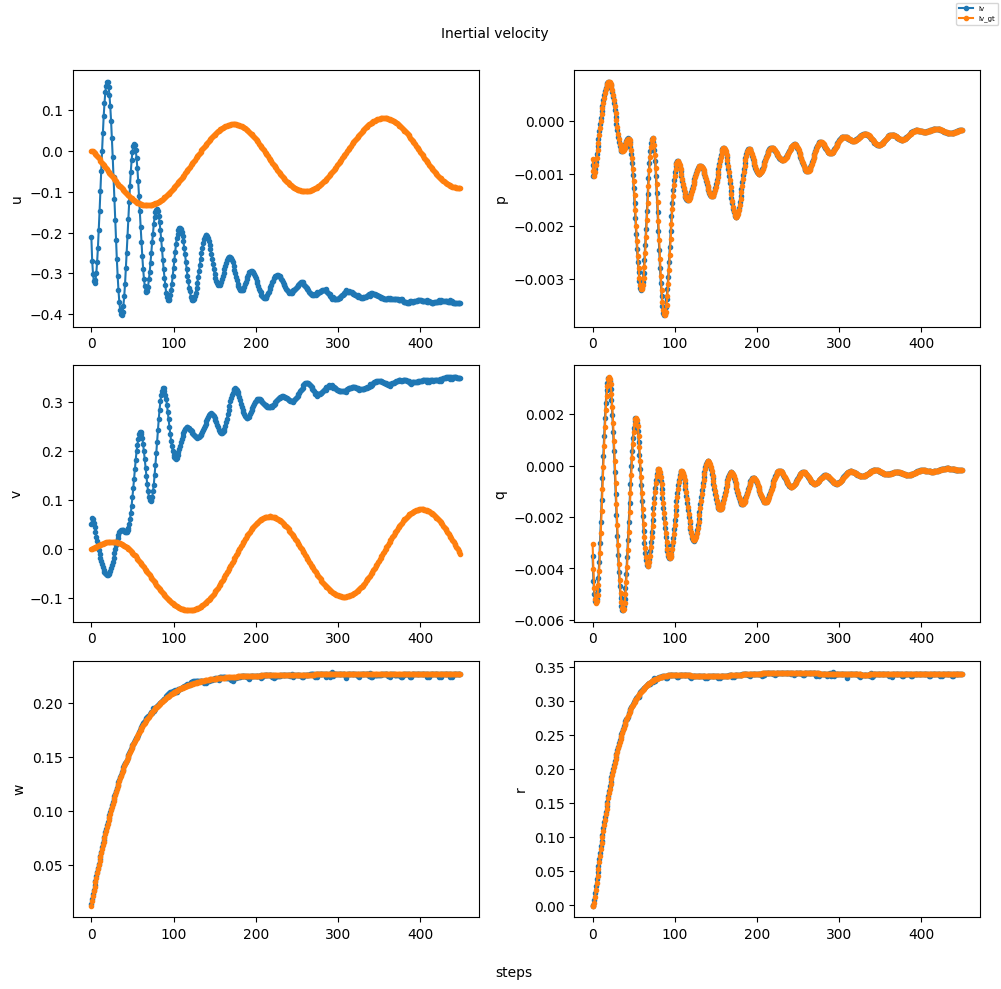

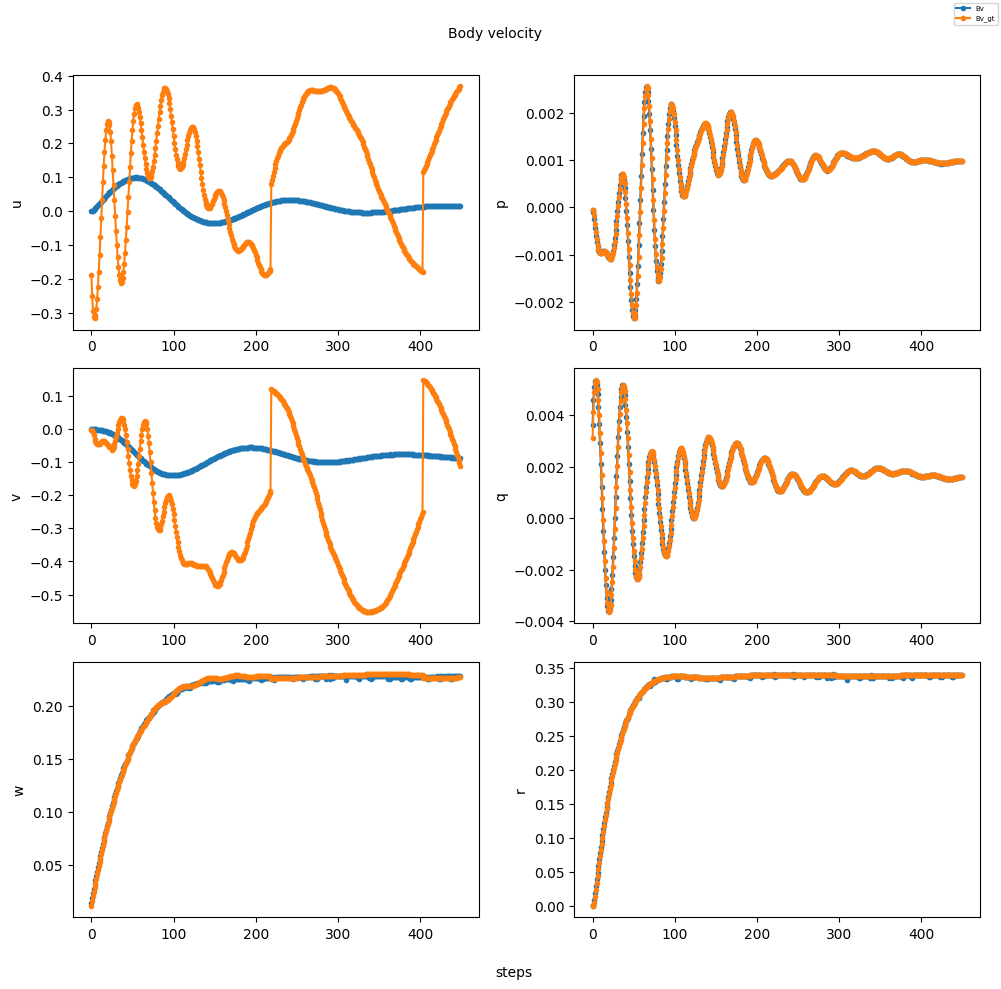

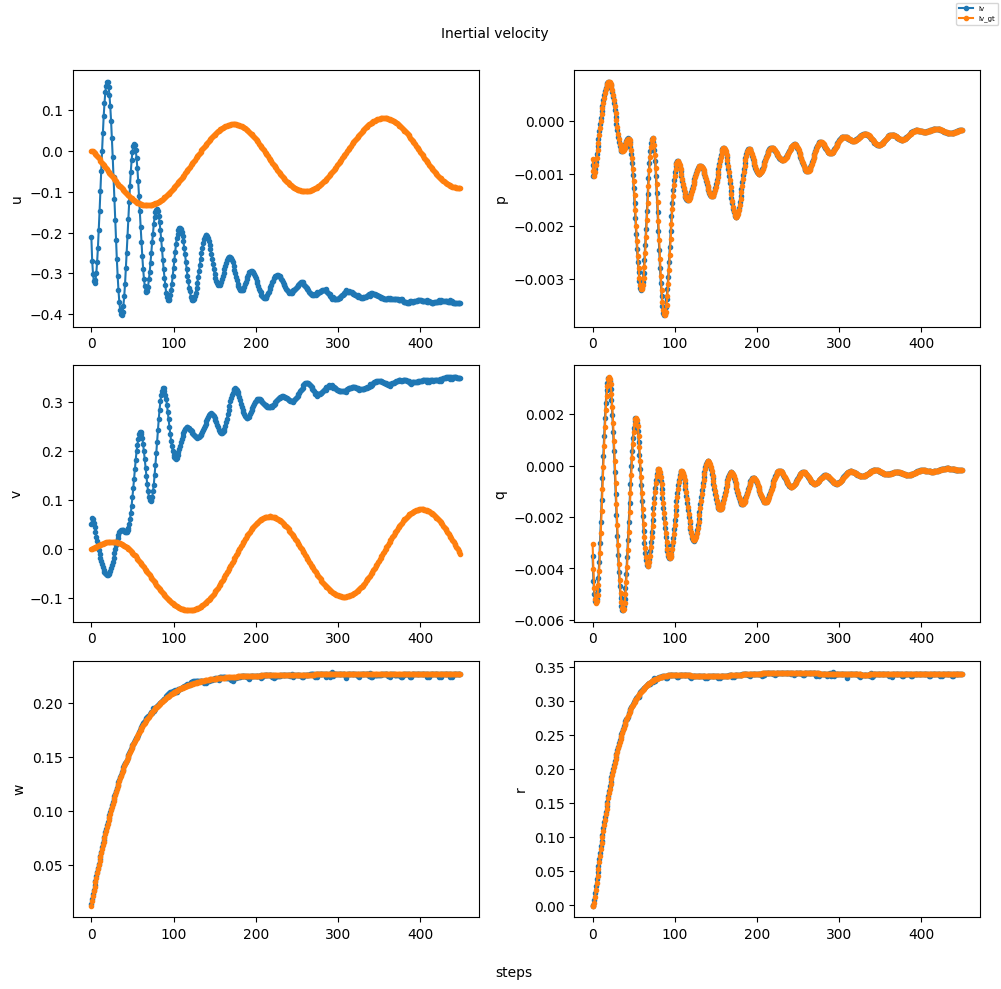

In [13]:
v_cols = {'u': 0, 'v': 1, 'w': 2, 'p': 3, 'q': 4, 'r': 5}


plot_traj({"Bv": Bv, "Bv_gt": B_vel}, v_cols, 450, True, "Body velocity", True)
plot_traj({"Iv": Iv, "Iv_gt": I_vel}, v_cols, 450, True, "Inertial velocity", True)


### 4.4 Integrate the trajectory.

In [15]:
I_vel_traj = np.zeros(shape=(500, 6))
I_vel_traj[0] = euler_traj[0]
B_vel_traj = np.zeros(shape=(500, 6))
B_vel_traj[0] = euler_traj[0]

I_X_init = pp.SE3(quat_traj[0])
B_X_init = pp.SE3(quat_traj[0])

X = I_X_init
for i, iv in enumerate(Iv):
    X_next = pp.se3(iv * dt).Exp() * X
    s = X_next.data.numpy()
    p = s[0:3]
    q = s[3:]
    r = R.from_quat(q)
    euler = r.as_euler('xyz')
    I_vel_traj[i+1] = np.concatenate([p, euler])
    
    X = X_next
    
X = B_X_init
for i, bv in enumerate(Bv):
    X_next = X * pp.se3(bv * dt).Exp()
    s = X_next.data.numpy()
    p = s[0:3]
    q = s[3:]
    r = R.from_quat(q)
    euler = r.as_euler('xyz')
    B_vel_traj[i+1] = np.concatenate([p, euler])
    
    X = X_next

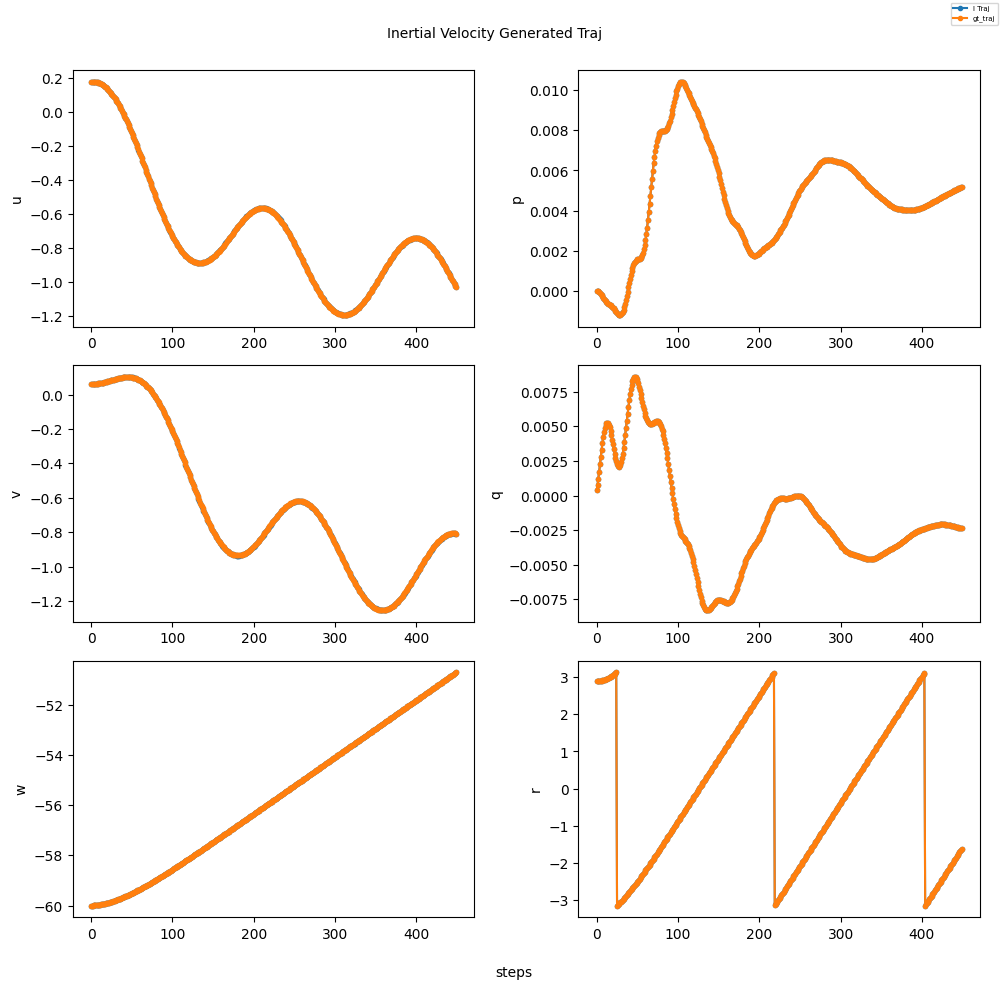

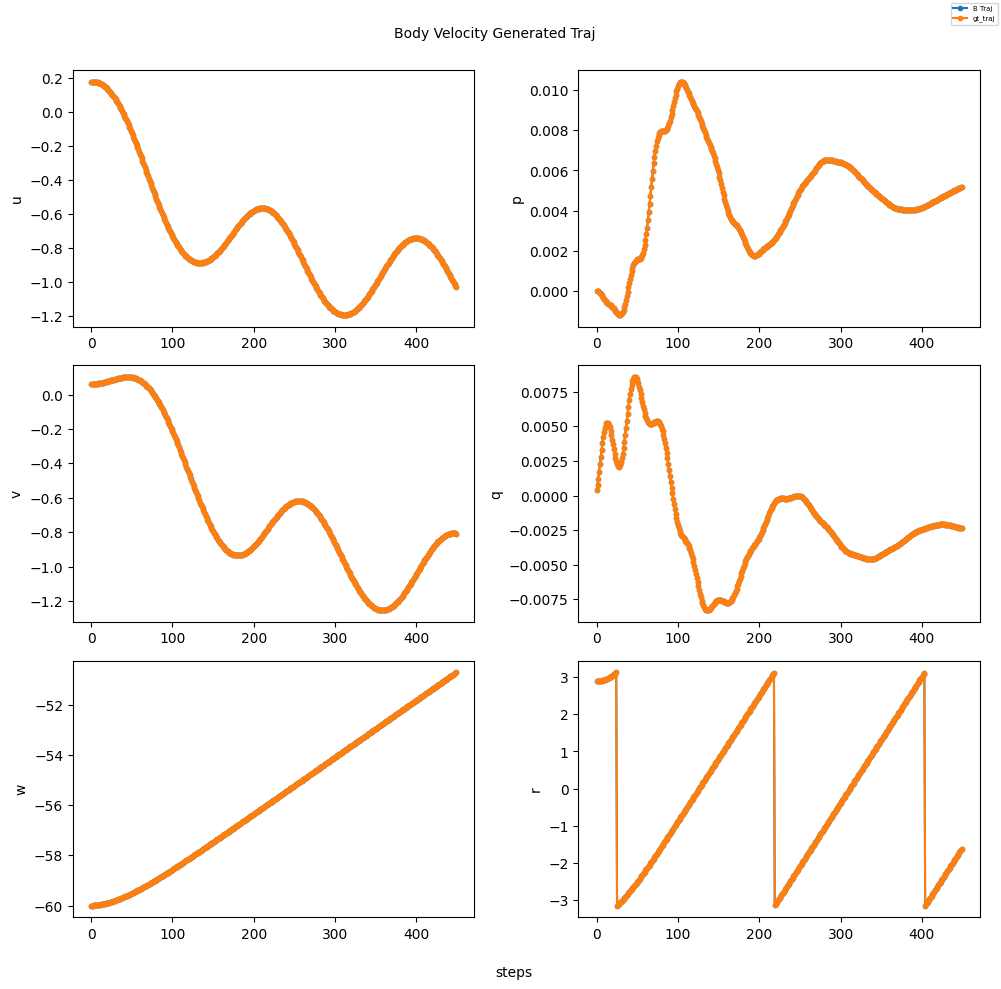

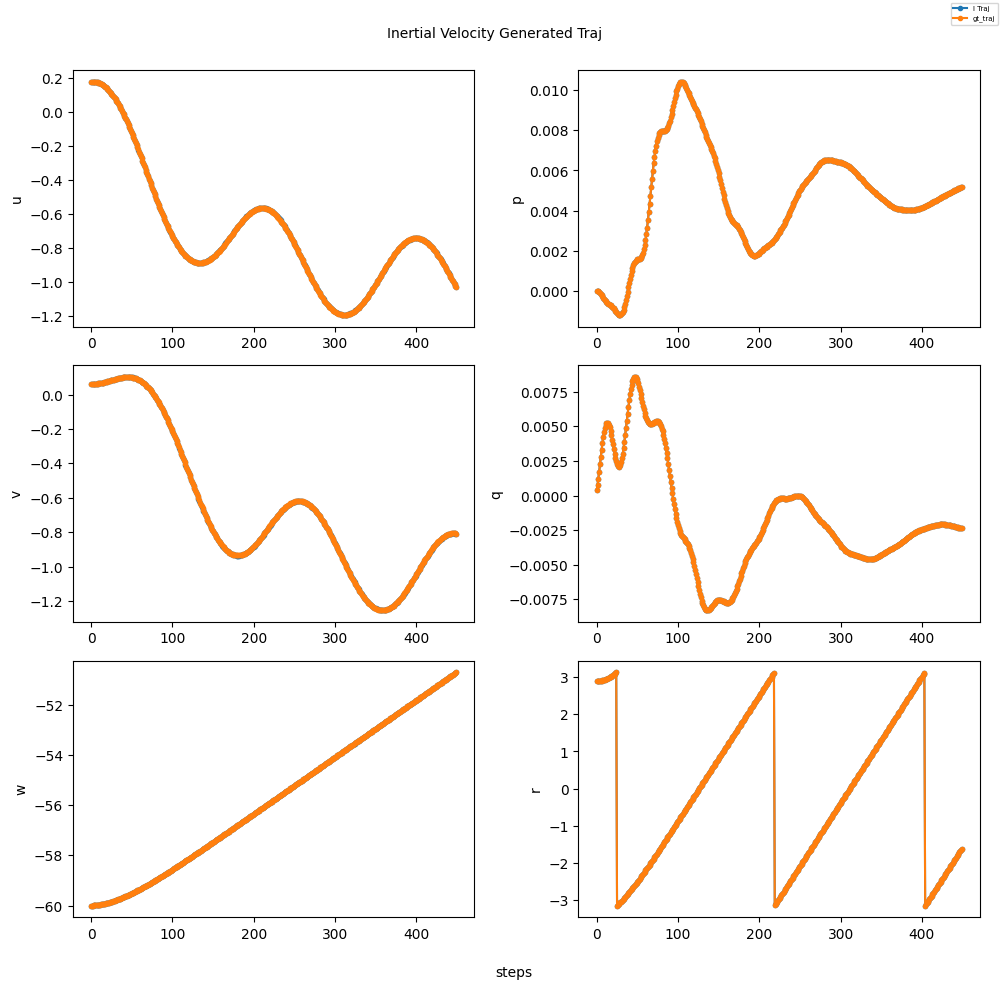

In [16]:

s_cols = {'x': 0, 'y': 1, 'z': 2, 'roll': 3, 'pitch': 4, 'yaw': 5}


plot_traj({"B Traj": B_vel_traj, "gt_traj": euler_traj}, v_cols, 450, True, "Body Velocity Generated Traj", True)
plot_traj({"I Traj": I_vel_traj, "gt_traj": euler_traj}, v_cols, 450, True, "Inertial Velocity Generated Traj", True)